# using gradient boosted decision trees as a meta-classifier

In [2]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'stringr'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

[1] "stringr"      "pROC"         "tidyr"        "dplyr"        "glmnet"      
 [6] "foreach"      "Matrix"       "xgboost"      "ggplot2"      "RColorBrewer"
[11] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[16] "methods"      "base"

In [3]:
split_data <- function(outcomes,p=0.75) {
    n <- length(outcomes)
    s <- floor(p*n)
    sample_inds <- sample(seq_len(n), size = s)
    return(sample_inds)
}

## Load data

In [4]:
# paul's data frame

tableName <- "ftClean.Fri.Sep.30.2016-18:02:21.RData"
directory <- "~/git-repos/BDDS/trenadb/featureTable/lymphoblast"
fullPath <- file.path(directory, tableName)
stopifnot(file.exists(fullPath))
load(fullPath)

# cory's motif to tf-class mapping
tf.fams.file <- "/local/Cory/for_Paul/motif_class_fam"
tf.fams.table <- read.delim(tf.fams.file, stringsAsFactors=FALSE)

In [5]:
str(ft.clean)

'data.frame':	96825 obs. of  11 variables:
 $ loc             : chr  "chr19:42000006-42000014" "chr19:42000007-42000019" "chr19:42000008-42000019" "chr19:42000009-42000018" ...
 $ motif           : chr  "MA0738.1" "MA0872.1" "LMO2.p2" "MA0522.2" ...
 $ samplecount.w   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ score.w         : num  -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
 $ samplecount.h   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ score.h         : num  16 16 16 16 16 16 16 16 16 16 ...
 $ csTF            : chr  NA NA NA NA ...
 $ csscore         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ motifscore      : num  11.2 10.2 10.3 12.2 11.7 ...
 $ motifpval       : num  6.51e-05 7.15e-05 5.84e-05 7.11e-05 5.93e-05 5.65e-05 6.02e-05 2.92e-05 6.78e-05 8.34e-05 ...
 $ totalsamplecount: num  18 18 18 18 18 18 18 18 18 18 ...


In [6]:
str(ft.clean)

'data.frame':	96825 obs. of  11 variables:
 $ loc             : chr  "chr19:42000006-42000014" "chr19:42000007-42000019" "chr19:42000008-42000019" "chr19:42000009-42000018" ...
 $ motif           : chr  "MA0738.1" "MA0872.1" "LMO2.p2" "MA0522.2" ...
 $ samplecount.w   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ score.w         : num  -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
 $ samplecount.h   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ score.h         : num  16 16 16 16 16 16 16 16 16 16 ...
 $ csTF            : chr  NA NA NA NA ...
 $ csscore         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ motifscore      : num  11.2 10.2 10.3 12.2 11.7 ...
 $ motifpval       : num  6.51e-05 7.15e-05 5.84e-05 7.11e-05 5.93e-05 5.65e-05 6.02e-05 2.92e-05 6.78e-05 8.34e-05 ...
 $ totalsamplecount: num  18 18 18 18 18 18 18 18 18 18 ...


In [7]:
str(tf.fams.table)

'data.frame':	519 obs. of  3 variables:
 $ ID    : chr  "MA0151.1 " "MA0601.1 " "MA0602.1 " "MA0004.1 " ...
 $ class : chr  "ARID domain factors " "ARID domain factors " "ARID domain factors " "Basic helix-loop-helix factors (bHLH) " ...
 $ family: chr  "ARID-related factors " "ARID-related factors " "ARID-related factors " "PAS domain factors " ...


## add tf classes as features

In [8]:
# check overlap of motif names from cory and paul

motif.names.from.cory <- str_replace_all(string=tf.fams.table$ID, pattern="[[:space:]]", repl="")
motif.names.from.paul <- unique(ft.clean$motif)

# motifs not occurring from sample data
from.cory.not.in.paul <- motif.names.from.cory[!(motif.names.from.cory %in% motif.names.from.paul)]

# motifs not mapped in cory's table
from.paul.not.in.cory <- motif.names.from.paul[!(motif.names.from.paul %in% motif.names.from.cory)]

# number of motifs that i'll use
from.paul.in.cory <- sort(motif.names.from.paul[(motif.names.from.paul %in% motif.names.from.cory)])
length(from.paul.in.cory)

[1] 510

In [9]:
# filter out the motifs in pauls' table that cory doesn' have tf classes for

ft.clean.corymotifs <- ft.clean %>% filter(motif %in% from.paul.in.cory)
str(ft.clean.corymotifs)

'data.frame':	76891 obs. of  11 variables:
 $ loc             : chr  "chr19:42000006-42000014" "chr19:42000007-42000019" "chr19:42000009-42000018" "chr19:42000009-42000018" ...
 $ motif           : chr  "MA0738.1" "MA0872.1" "MA0522.2" "MA0820.1" ...
 $ samplecount.w   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ score.w         : num  -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
 $ samplecount.h   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ score.h         : num  16 16 16 16 16 16 16 16 16 16 ...
 $ csTF            : chr  NA NA NA NA ...
 $ csscore         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ motifscore      : num  11.2 10.2 12.2 11.7 12.6 ...
 $ motifpval       : num  6.51e-05 7.15e-05 7.11e-05 5.93e-05 5.65e-05 2.92e-05 6.78e-05 8.34e-05 2.67e-05 5.65e-05 ...
 $ totalsamplecount: num  18 18 18 18 18 18 18 18 18 18 ...


In [10]:
# find unique tf class names from cory's list

class.names.nospaces <- str_replace_all(string=tf.fams.table$class, pattern="[[:space:]]", repl="")
unique.class.names.nospaces <- unique(class.names.nospaces)
double.entry.classes <- grep('::', unique.class.names.nospaces, value=TRUE)
dedoubled.classes <- unique(unlist(strsplit(double.entry.classes,'::')))

class.names.nospaces.minus.doubles <- unique.class.names.nospaces[!(unique.class.names.nospaces %in% double.entry.classes)]
class.names.final <- sort(unique(c(class.names.nospaces.minus.doubles,dedoubled.classes)))
length(class.names.final)

[1] 30

In [11]:
# cory's map: arrange so grepping on class column will yeild matches from paul's names

tf.fams.table.renamed <- tf.fams.table
tf.fams.table.renamed$ID <- str_replace_all(string=tf.fams.table.renamed$ID, pattern="[[:space:]]", repl="")
tf.fams.table.renamed <- tf.fams.table.renamed %>% filter(ID %in% from.paul.in.cory)
rownames(tf.fams.table.renamed) <- tf.fams.table.renamed$ID
tf.class.foreach.motif <- tf.fams.table.renamed[,-c(1)]

tf.class.foreach.motif$class <- str_replace_all(string=tf.class.foreach.motif$class, pattern="[[:space:]]", repl="")

In [12]:
# make sparse class / tf feature matrix map
# all zeros to start, fill in ones below
tf.motif.class.matrix <- matrix(0L, nrow = length(from.paul.in.cory), ncol = length(class.names.final))
rownames(tf.motif.class.matrix) <- from.paul.in.cory
colnames(tf.motif.class.matrix) <- class.names.final

# loop through tfs and classes to fill in ones where there is a match

for (tf.name in rownames(tf.motif.class.matrix)) {
    for (class.name in colnames(tf.motif.class.matrix)) {
        class.to.check <- tf.class.foreach.motif[tf.name,'class']
        classes.match <- any(grep(class.name, class.to.check, value=FALSE, fixed=TRUE))
        if (classes.match == 1) {
            tf.motif.class.matrix[tf.name,class.name] <- 1
        }
    }
    
}

In [13]:
# number of motifs with extra entries is small:
dim(tf.motif.class.matrix)[1]
sum(tf.motif.class.matrix)

# check to see if any motifs didn't match
rownames(tf.motif.class.matrix)[rowSums(tf.motif.class.matrix) == 0]

[1] 510

[1] 513

character(0)

In [14]:
# tf class distribution
colSums(tf.motif.class.matrix)

ARIDdomainfactors   Basichelix-loop-helixfactors(bHLH) 
                                   2                                   62 
  Basichelix-span-helixfactors(bHSH)      Basicleucinezipperfactors(bZIP) 
                                   9                                   43 
      C2CHTHAP-typezincfingerfactors                C2H2zincfingerfactors 
                                   1                                   56 
                           CRCdomain  DM-typeintertwinedzincfingerfactors 
                                   1                                    1 
         Forkhead/wingedhelixfactors                     GCMdomainfactors 
                                  36                                    2 
             Grainyheaddomainfactors                     Heatshockfactors 
                                   2                                    3 
     HeteromericCCAAT-bindingfactors High-mobilitygroup(HMG)domainfactors 
                                   2                                   13 
                  Homeodomainfactors                       MADSboxfactors 
                                 145                                    5 
   NuclearreceptorswithC4zincfingers        OtherC4zincfinger-typefactors 
                                  36                                    6 
                    p53domainfactors                     Pairedboxfactors 
                                   3                                    8 
                   Psq-typeHTHdomain        Relhomologyregion(RHR)factors 
                                   1                                    9 
                   Runtdomainfactors                    SANDdomainfactors 
                                   3                                    2 
   SMAD/NF-1DNA-bindingdomainfactors                    STATdomainfactors 
                                   5                                    6 
                        T-Boxfactors                 TATA-bindingproteins 
                                  12                                    1 
                    TEAdomainfactors             Tryptophanclusterfactors 
                                   4                                   34

In [15]:
# add class info to paul's data frame in pseudo 1-hot encoding

dummy.classes <- matrix(0L, nrow = dim(ft.clean.corymotifs)[1], ncol = dim(tf.motif.class.matrix)[2])
colnames(dummy.classes) <- colnames(tf.motif.class.matrix)
ft.clean.corymotifs.tfclasses <- cbind(ft.clean.corymotifs,dummy.classes)

for (r in rownames(tf.motif.class.matrix)) {
    
    n.rows.to.update <- dim(ft.clean.corymotifs.tfclasses[ft.clean.corymotifs.tfclasses$motif == r,
                                  colnames(tf.motif.class.matrix)])[1]
    
    ft.clean.corymotifs.tfclasses[ft.clean.corymotifs.tfclasses$motif == r,
                                  colnames(tf.motif.class.matrix)] <- tf.motif.class.matrix[c(rep(r,n.rows.to.update)),]
}

In [16]:
# check to see if any loc/motifs didn't get a class
rownames(ft.clean.corymotifs.tfclasses)[rowSums(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)]) == 0]

character(0)

In [17]:
# most entries just have one class
dim(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])[1]
sum(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])

[1] 76891

[1] 77193

## Split data into feature matrix and output

In [18]:
y <- as.numeric(ft.clean.corymotifs.tfclasses$csscore > 0)

In [19]:
cols.to.drop <- c("csscore", "csTF", "motif", "loc", "totalsamplecount")

X <- ft.clean.corymotifs.tfclasses[,!(colnames(ft.clean.corymotifs.tfclasses) %in% cols.to.drop)]

In [30]:
t(X[1:3,])

,1,2,3
samplecount.w,0.0000000,0.0000000,0.0000000
score.w,-99.0000000,-99.0000000,-99.0000000
samplecount.h,1.0000000,1.0000000,1.0000000
score.h,16.0000000,16.0000000,16.0000000
motifscore,11.1636000,10.1967000,12.2308000
motifpval,0.0000651,0.0000715,0.0000711
ARIDdomainfactors,0.0000000,0.0000000,0.0000000
Basichelix-loop-helixfactors(bHLH),0.0000000,0.0000000,1.0000000
Basichelix-span-helixfactors(bHSH),0.0000000,1.0000000,0.0000000
Basicleucinezipperfactors(bZIP),0.0000000,0.0000000,0.0000000


In [22]:
train.inds <- split_data(y)

X.train <- X[train.inds,]
X.test <- X[-train.inds,]
y.train <- y[train.inds]
y.test <- y[-train.inds]

In [26]:
str(as.matrix(X.train))
str(y)

 num [1:57668, 1:36] 0 0 0 1 0 0 0 0 0 1 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:57668] "52108" "1372" "15102" "21518" ...
  ..$ : chr [1:36] "samplecount.w" "score.w" "samplecount.h" "score.h" ...
 num [1:76891] 0 0 0 0 0 0 0 0 0 0 ...


In [28]:
param <- list("objective" = "binary:logistic",
              "max.depth" = 5,
              "eta" = 0.01
              )

gbdt <- xgboost(
    params = param,
    data = as.matrix(X.train),
    label = y.train,
    nround = 100,
    verbose = TRUE,
    missing = NA
)

[0]	train-error:0.098304
[1]	train-error:0.098304
[2]	train-error:0.098304
[3]	train-error:0.098304
[4]	train-error:0.098304
[5]	train-error:0.098304
[6]	train-error:0.098443
[7]	train-error:0.098443
[8]	train-error:0.098183
[9]	train-error:0.098183
[10]	train-error:0.098183
[11]	train-error:0.098183
[12]	train-error:0.097940
[13]	train-error:0.097940
[14]	train-error:0.097940
[15]	train-error:0.097957
[16]	train-error:0.097957
[17]	train-error:0.097957
[18]	train-error:0.097957
[19]	train-error:0.097957
[20]	train-error:0.097784
[21]	train-error:0.097593
[22]	train-error:0.097749
[23]	train-error:0.097593
[24]	train-error:0.097593
[25]	train-error:0.097593
[26]	train-error:0.097593
[27]	train-error:0.097593
[28]	train-error:0.097593
[29]	train-error:0.097593
[30]	train-error:0.097610
[31]	train-error:0.097558
[32]	train-error:0.097229
[33]	train-error:0.097298
[34]	train-error:0.097229
[35]	train-error:0.097194
[36]	train-error:0.097246
[37]	train-error:0.097246
[38]	train-error:0.097

In [37]:
preds.holdout <- predict(gbdt,as.matrix(X.test), missing=NA)
preds.overfit <- predict(gbdt,as.matrix(X.train), missing=NA)

mean(round(preds.holdout) == y.test)
mean(round(preds.overfit) == y.train)

[1] 0.9061541

[1] 0.9038115


Call:
roc.default(response = y.train, predictor = preds.overfit)

Data: preds.overfit in 49601 controls (y.train 0) < 8067 cases (y.train 1).
Area under the curve: 0.8849

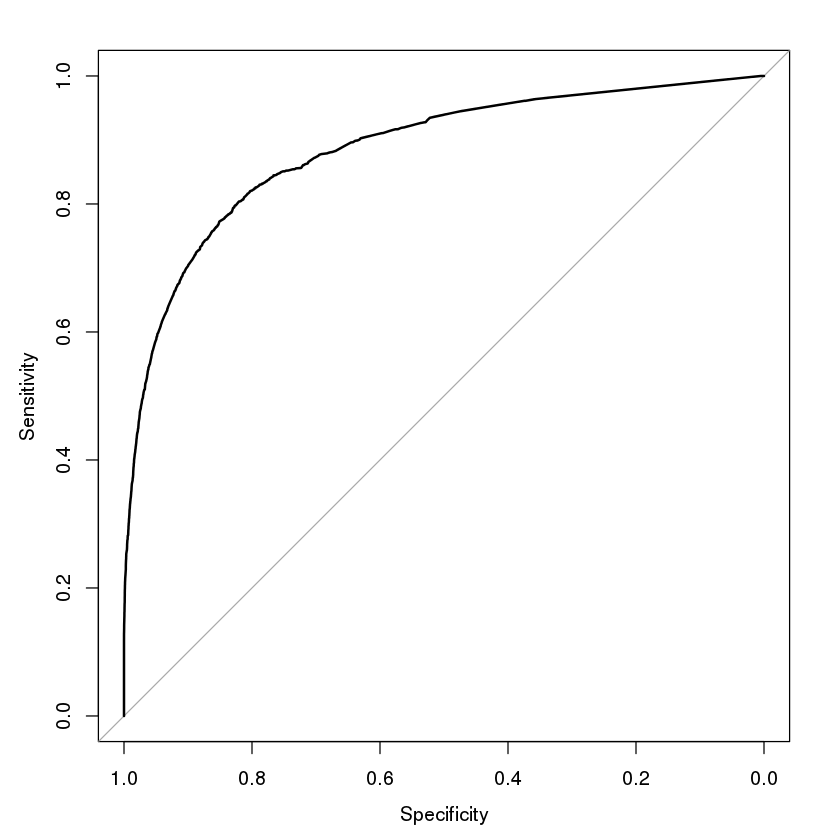

In [39]:
roc.motifs.overfit <- roc(y.train, preds.overfit)
plot(roc.motifs.overfit)


Call:
roc.default(response = y.test, predictor = preds.holdout)

Data: preds.holdout in 16590 controls (y.test 0) < 2633 cases (y.test 1).
Area under the curve: 0.8793

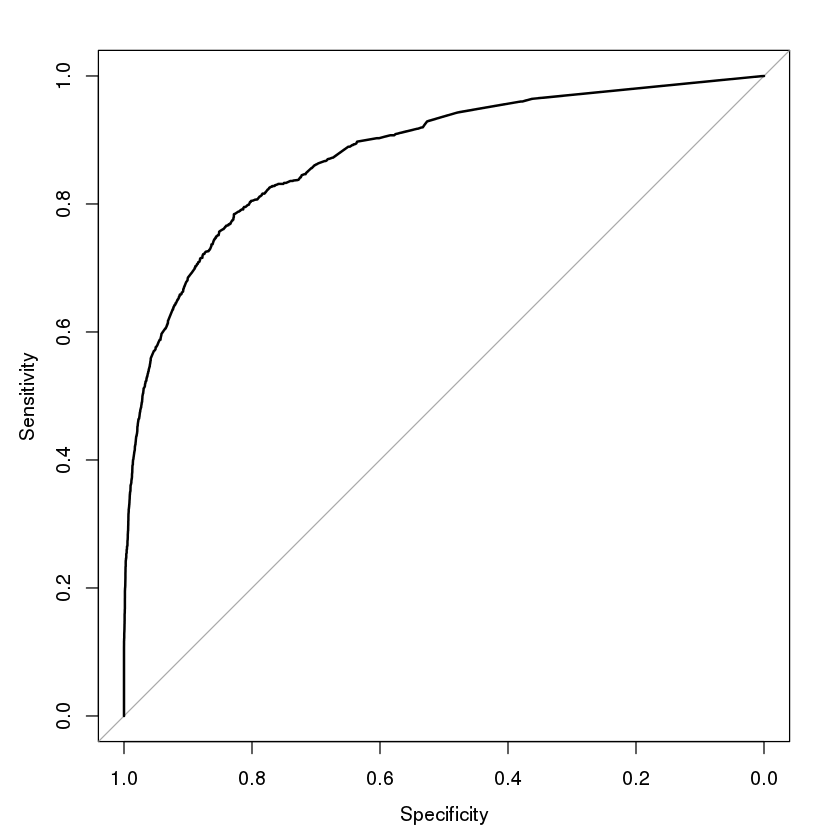

In [35]:
roc.motifs <- roc(y.test, preds.holdout)
# ci.motifs <- ci(roc.motifs, of = "se", sp = seq(0, 1, 0.01))
plot(roc.motifs)
# plot(ci.motifs, type="shape")

[1]    0   10   25   97 7460

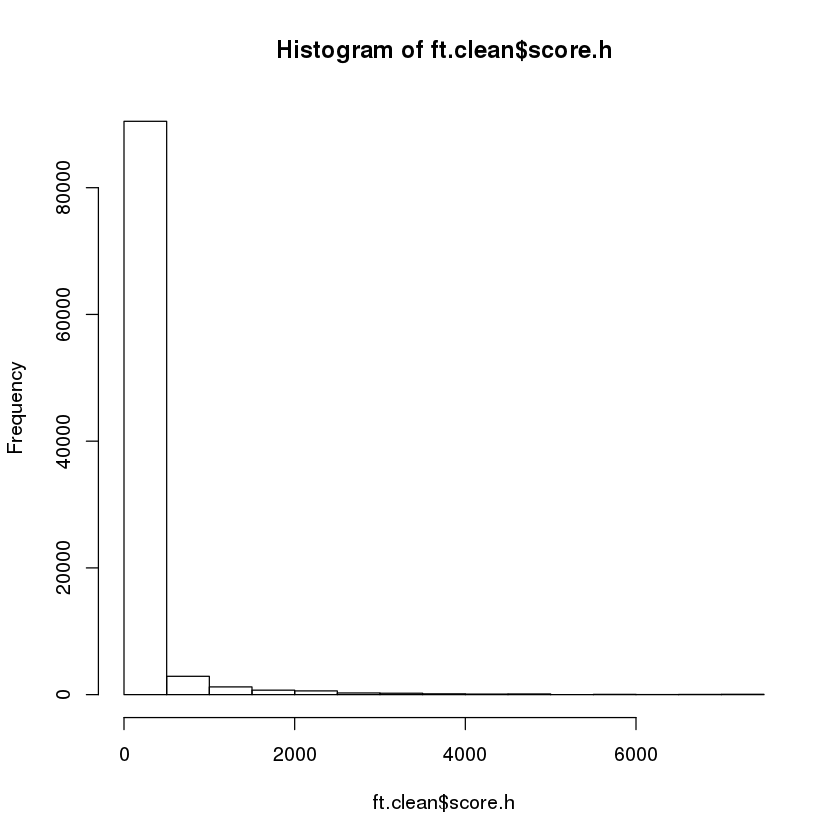

In [10]:
fivenum(ft.clean$score.h)
hist(ft.clean$score.h)

[1] -1000.0000   -99.0000   -99.0000   -17.0816   -10.0004

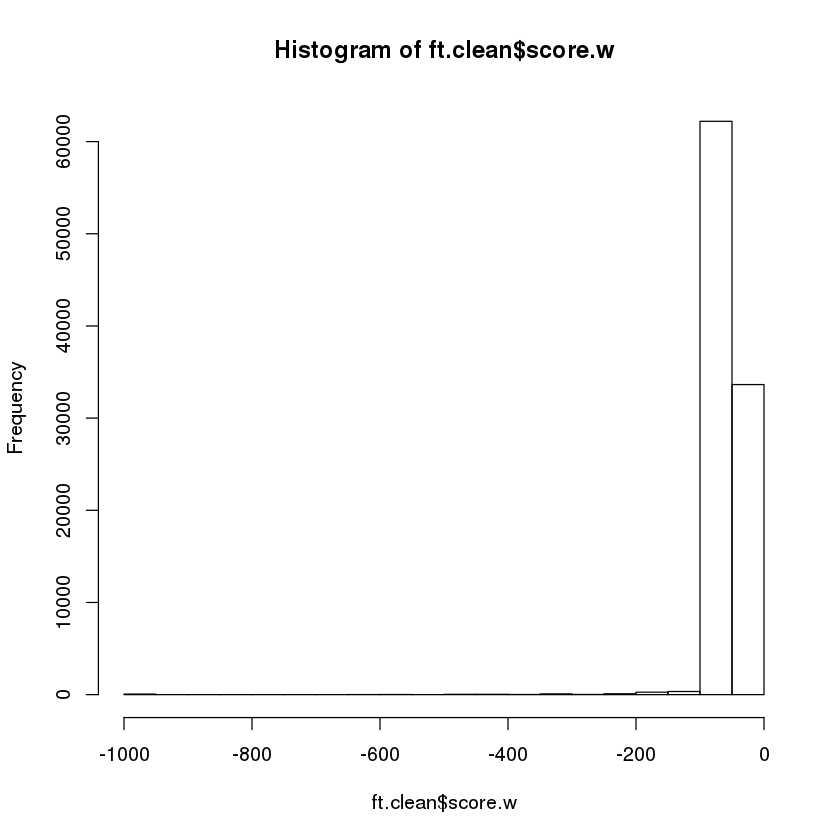

In [12]:
fivenum(ft.clean$score.w)
hist(ft.clean$score.w)

[1] 2.11e-13 7.68e-06 2.65e-05 5.87e-05 1.00e+00

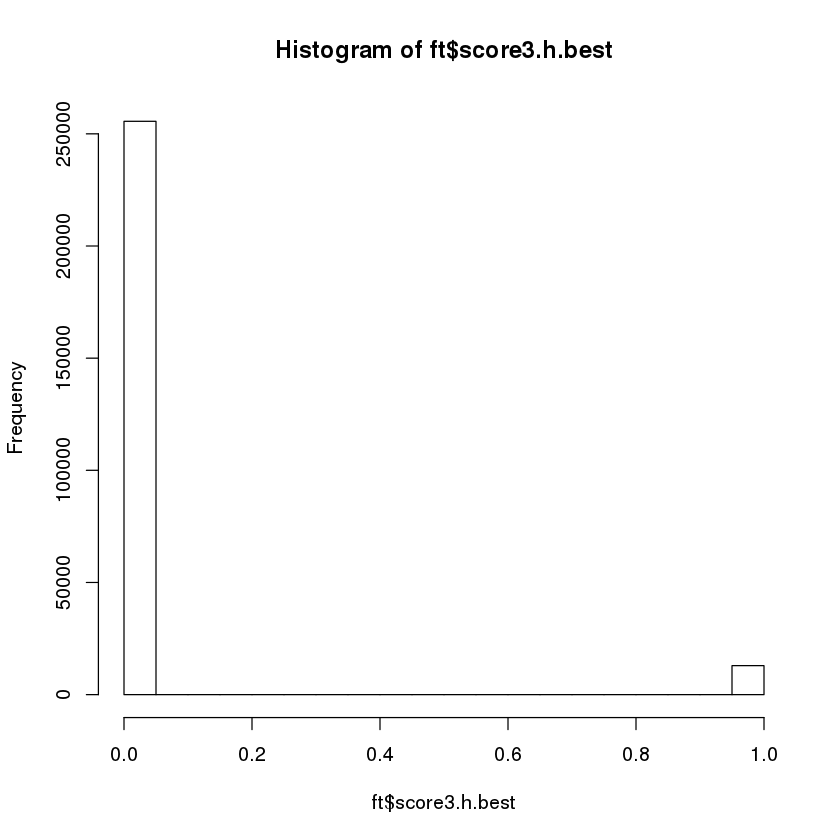

In [63]:
fivenum(ft$score3.h.best)
hist(ft$score3.h.best)

[1] 2.11e-13 7.30e-06 2.44e-05 5.20e-05 1.00e-04

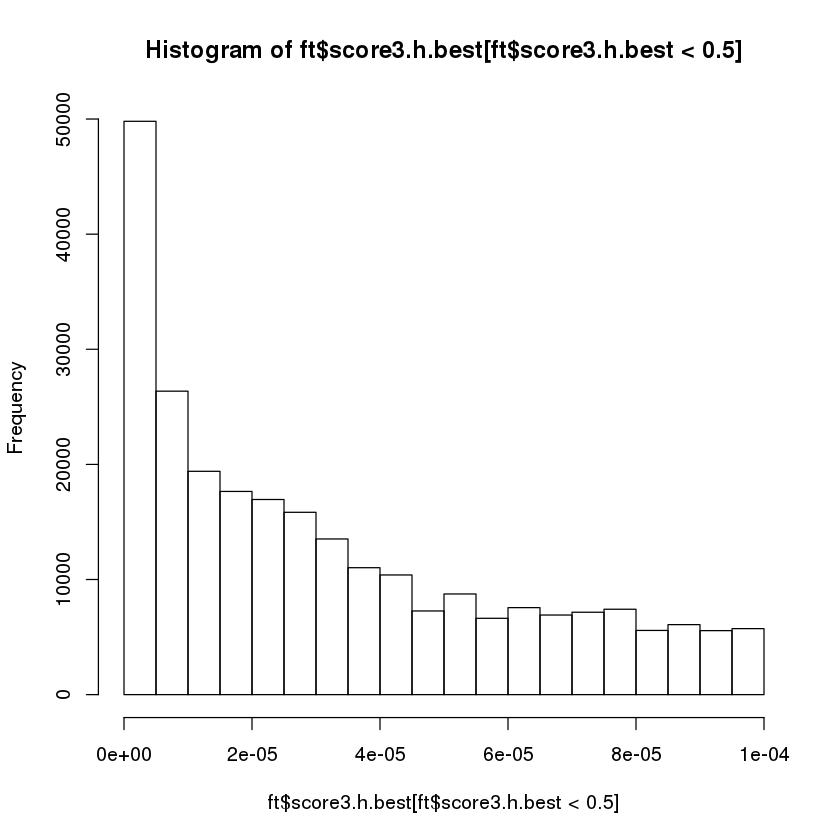

In [65]:
fivenum(ft$score3.h.best[ft$score3.h.best < 0.5])
hist(ft$score3.h.best[ft$score3.h.best < 0.5])

[1] 1.10e-11 5.60e-06 2.04e-05 4.30e-05 1.00e-04

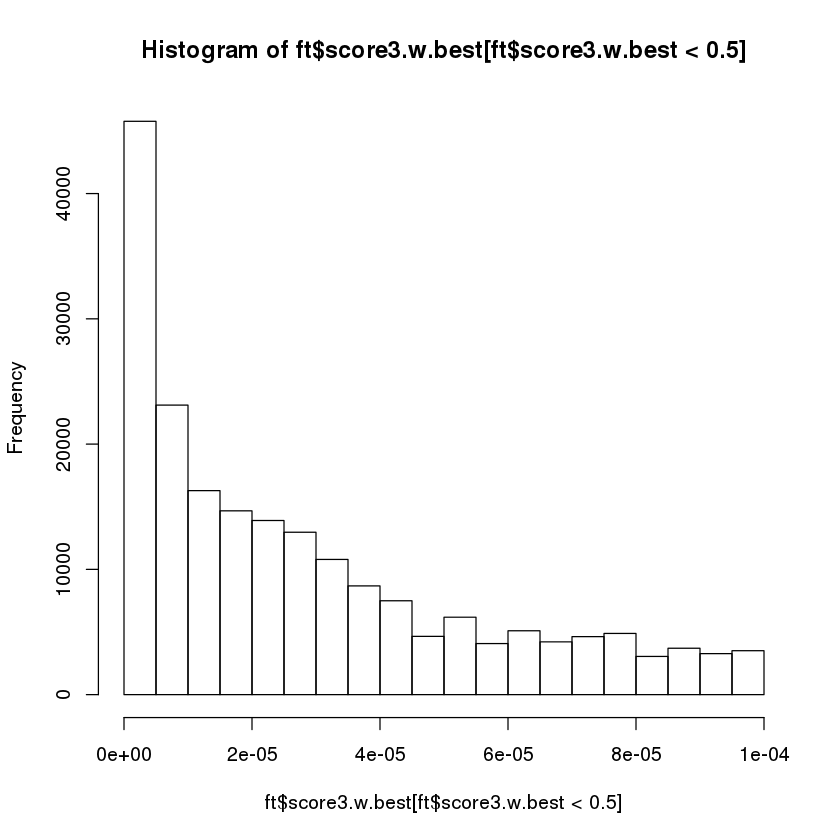

In [67]:
fivenum(ft$score3.w.best[ft$score3.w.best < 0.5])
hist(ft$score3.w.best[ft$score3.w.best < 0.5])

In [76]:
tbl_hw <- ft[(ft$samplecount.w >= 1) & (ft$samplecount.h >= 1),]

In [77]:
head(tbl_hw[,c('score2.h.best','score2.w.best','score3.h.best','score3.w.best')])

,score2.h.best,score2.w.best,score3.h.best,score3.w.best
55,16.5505,16.5505,1.67e-06,1.67e-06
56,13.4082,13.4310,1.35e-05,1.35e-05
57,11.9024,13.4310,3.79e-05,1.35e-05
58,13.4310,13.4310,1.35e-05,1.35e-05
59,13.4082,13.4082,1.35e-05,1.35e-05
60,11.9024,13.4082,3.79e-05,1.35e-05


In [78]:
mean(tbl_hw$score2.h.best == tbl_hw$score2.w.best)

[1] 0.2048227

In [71]:
mean(tbl_hw$score3.h.best == tbl_hw$score3.w.best)

[1] 0.2568434

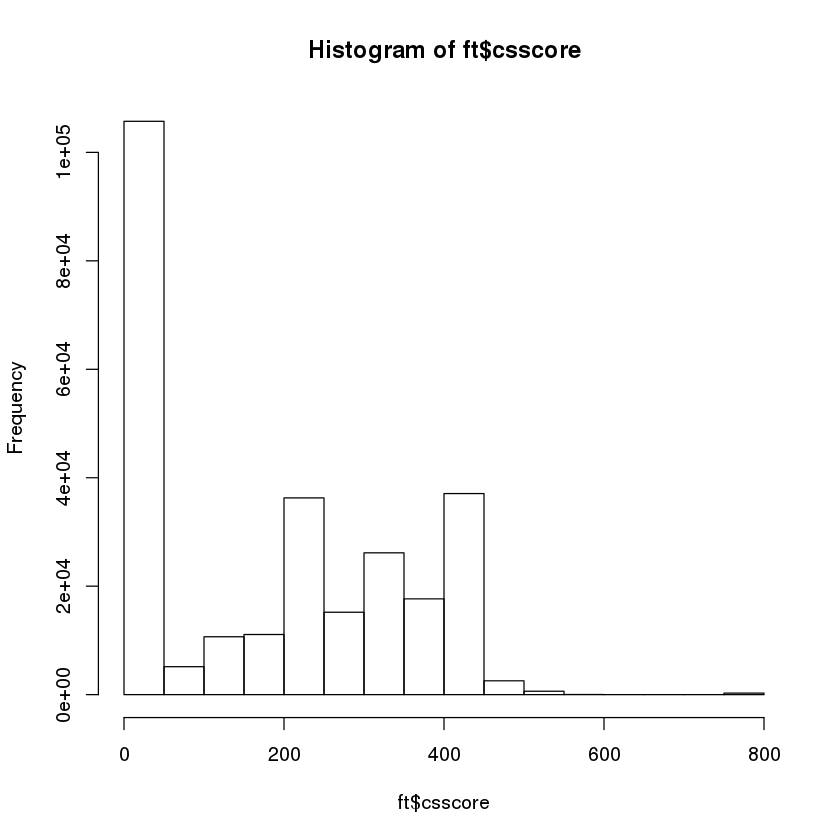

In [72]:
hist(ft$csscore)

In [75]:
mean(ft$csscore > 0)

[1] 0.6299281

## classify iris data using three different base learners

In [33]:
data(iris)

In [34]:
df_nosetosa <- iris[iris$Species != "setosa",]
df_nosetosa$Species <- factor(df_nosetosa$Species)
rownames(df_nosetosa) <- NULL
X <- df_nosetosa[,-c(5)]
y <- as.numeric(df_nosetosa[,c(5)]) - 1

traintest_inds <- split_data(y,p=0.75)
X_traintest <- X[c(traintest_inds),]
y_traintest <- y[traintest_inds]
X_holdout <- X[-traintest_inds,]
y_holdout <- y[-traintest_inds]

df_nosetosa_train <- df_nosetosa[traintest_inds,]
df_nosetosa_test <- df_nosetosa[-traintest_inds,]

In [35]:
glm_sl <- glm(Species ~ Sepal.Length, data=df_nosetosa_train, family=binomial)
glm_sw <- glm(Species ~ Sepal.Width, data=df_nosetosa_train, family=binomial)
glm_pl <- glm(Species ~ Petal.Length, data=df_nosetosa_train, family=binomial)

### training accuracy for each base learner

In [36]:
mean(round(glm_sl$fitted.values) == y_traintest)
mean(round(glm_sw$fitted.values) == y_traintest)
mean(round(glm_pl$fitted.values) == y_traintest)

[1] 0.72

[1] 0.5466667

[1] 0.92

### construct meta-features using the predictions of the three base learners

In [37]:
df_meta <- data.frame("sl.score"=glm_sl$fitted.values,
                      "sw.score"=glm_sw$fitted.values,
                      "pl.score"=glm_pl$fitted.values)

### majority vote isn't that great when some of the voters are significantly worse than others

In [38]:
mean(round(rowMeans(round(df_meta),1)) == y_traintest)

[1] 0.7733333

## instead, learn a decision tree in a meta-feature space
meta features are the scores from the base learners

In [39]:
param <- list("objective" = "binary:logistic",
              "max.depth" = 2,
              "eta" = 0.25
              )

gbdt <- xgboost(
    params = param,
    data = as.matrix(df_meta),
    label = as.numeric(y_traintest),
    nround = 10,
    verbose = FALSE,
    missing=NA
)

### training accuracy of the meta-classifier 

In [40]:
preds_overfit <- predict(gbdt,as.matrix(df_meta), missing=NA)
mean(round(preds_overfit) == y_traintest)

[1] 0.9333333

### test accuracies of the base learners

In [18]:
preds_holdout_sl <- predict.glm(object = glm_sl, newdata = df_nosetosa_test, type = "response")
preds_holdout_sw <- predict.glm(object = glm_sw, newdata = df_nosetosa_test, type = "response")
preds_holdout_pl <- predict.glm(object = glm_pl, newdata = df_nosetosa_test, type = "response")

mean(round(preds_holdout_sl) == y_holdout)
mean(round(preds_holdout_sw) == y_holdout)
mean(round(preds_holdout_pl) == y_holdout)

df_meta_test <- data.frame("sl.score"=preds_holdout_sl,
                           "sw.score"=preds_holdout_sw,
                           "pl.score"=preds_holdout_pl)

[1] 0.6

[1] 0.48

[1] 0.88

### test accuracy of the meta-classifier

In [19]:
preds_holdout <- predict(gbdt,as.matrix(df_meta_test), missing=NA)
mean(round(preds_holdout) == y_holdout)

[1] 0.88

# ROC curves

In [25]:
data(aSAH)

In [27]:
rocs100 <- roc(aSAH$outcome, aSAH$s100, percent = TRUE, partial.auc=c(100, 90))
rocwfns <- roc(aSAH$outcome, aSAH$wfns, percent = TRUE, partial.auc=c(100, 90))

In [28]:
cis100 <- ci(rocs100, of = "se", sp = seq(0, 100, 5), boot.n=10000)
ciwfns <- ci(rocwfns, of = "threshold", threshold=4.5, boot.n=10000)

In [29]:
rtest <- roc.test(rocs100, rocwfns, boot.n=10000)


Call:
roc.default(response = aSAH$outcome, predictor = aSAH$s100, percent = TRUE,     partial.auc = c(100, 90))

Data: aSAH$s100 in 72 controls (aSAH$outcome Good) < 41 cases (aSAH$outcome Poor).
Partial area under the curve (specificity 100%-90%): 3.276%


Call:
roc.default(response = aSAH$outcome, predictor = aSAH$wfns, percent = TRUE,     partial.auc = c(100, 90))

Data: aSAH$wfns in 72 controls (aSAH$outcome Good) < 41 cases (aSAH$outcome Poor).
Partial area under the curve (specificity 100%-90%): 3.344%

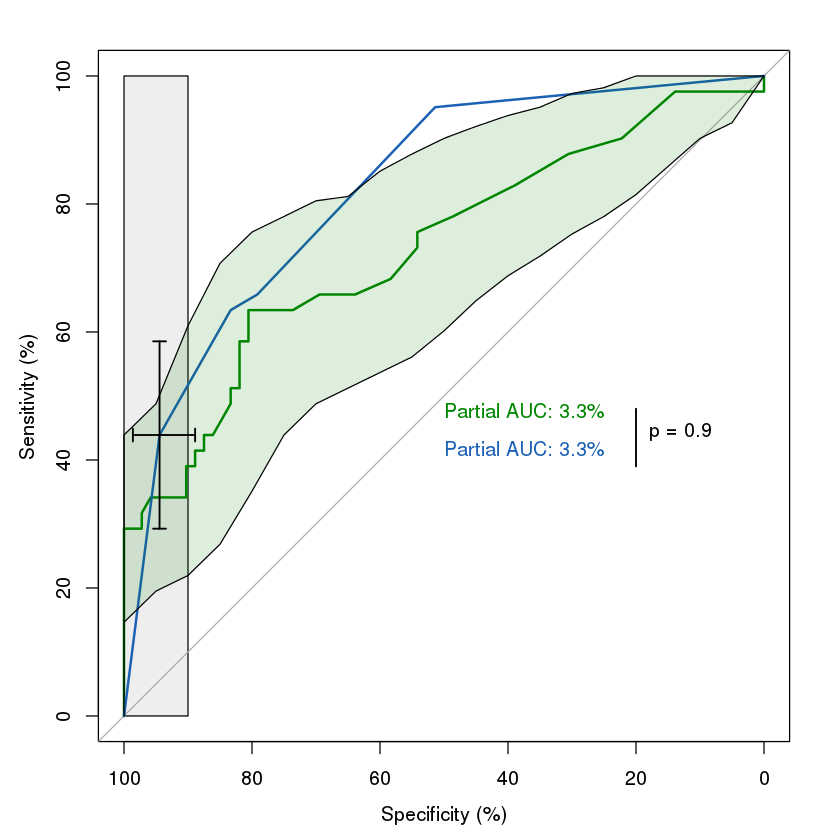

In [30]:
# png("demo.png")
plot(rocs100, col="#008600", max.auc.polygon=TRUE, print.auc=TRUE, print.auc.y=48)
plot(rocwfns, col="#1c61b6", add=TRUE, print.auc=TRUE, print.auc.y=42)
plot(cis100, type="shape", col="#00860022", no.roc=TRUE)
plot(ciwfns, type="bars", lwd=1.5)
text(18, 45, sprintf("p = %.1f", rtest$p.value), adj=c(0,1))
lines(c(20, 20), c(39, 48), lwd=1.5)
# dev.off()

In [54]:
roc_iris <- roc(y_holdout, preds_holdout)
ci_iris <- ci(roc_iris, of = "se", sp = seq(0, 1, 0.01))


Call:
roc.default(response = y_holdout, predictor = preds_holdout)

Data: preds_holdout in 13 controls (y_holdout 0) < 12 cases (y_holdout 1).
Area under the curve: 0.9071

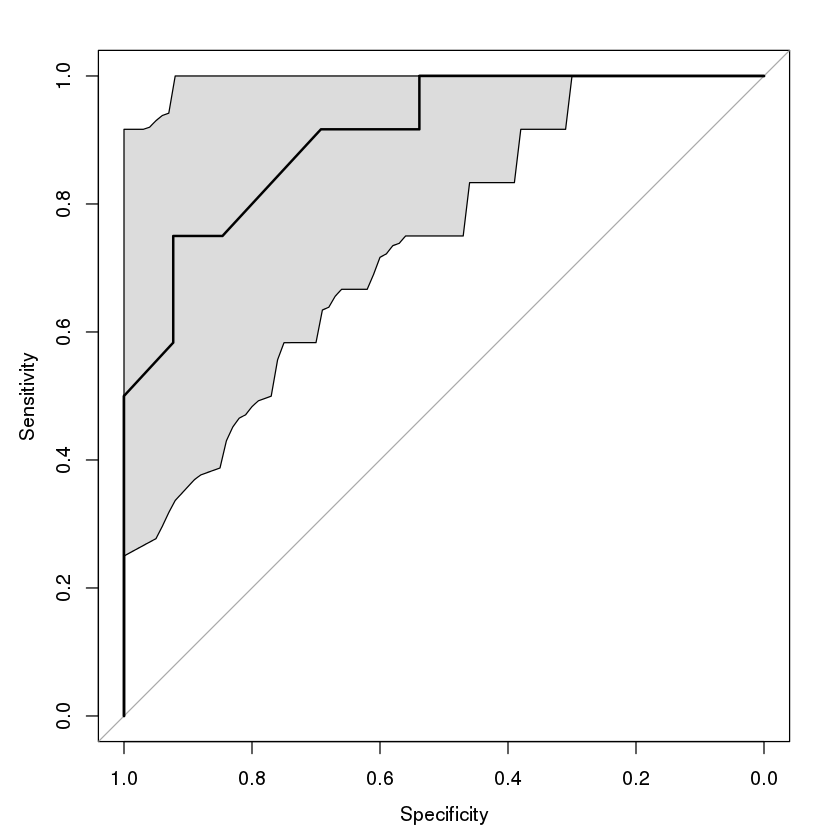

In [55]:
plot(roc_iris)
plot(ci_iris, type="shape")

In [132]:
mattcc <- function(true_classes, predicted_classes) {
        
    pos <- true_classes == 1
    neg <- true_classes == 0
    
    TP <- sum( predicted_classes[pos] == true_classes[pos] )
    TN <- sum( predicted_classes[neg] == true_classes[neg] )
    FP <- sum( predicted_classes[pos] != true_classes[pos] )
    FN <- sum( predicted_classes[neg] != true_classes[neg] )  
    
    N1 <- TP*TN
    N2 <- FP*FN
    D1 <- TP+FP
    D2 <- TP+FN
    D3 <- TN+FP
    D4 <- TN+FN
    
    N <- N1-N2
    D <- D1*D2*D3*D4
    
    if (D==0) {
        m <- 0
    } else {
        M <- N/sqrt(D)
    }
    
    return(M)
}

In [133]:
mattcc(y_holdout, round(preds_holdout))

[1] 0.6000125

In [134]:
mattcc(y_traintest,round(preds_overfit))

[1] 0.8692937